# NIR Behavioral Pipeline — Complete Setup & Usage Guide

This notebook walks you through **everything** needed to:
1. Set up the Julia environment and install all required packages
2. Set up the Python (conda) environment
3. Prepare your data files
4. Create the Julia `data_dict` dictionary and compute worm splines
5. Synchronize NIR and confocal camera timing
6. Compute behavioral metrics (velocity, curvature, body angles, etc.)
7. Export aligned data for downstream analysis

---

## Table of Contents
- [Part 0: Prerequisites & File Checklist](#part-0)
- [Part 1: Julia Environment Setup](#part-1)
- [Part 2: Python / Conda Environment Setup](#part-2)
- [Part 3: Understanding the HDF5 Data File](#part-3)
- [Part 4: Computing the Worm Spline (Julia)](#part-4)
- [Part 5: NIR–Confocal Synchronization (Python)](#part-5)
- [Part 6: Computing Behavioral Metrics (Julia)](#part-6)
- [Part 7: Working with Synced Data in Python](#part-7)
- [Part 8: Troubleshooting](#part-8)

<a id="part-0"></a>
## Part 0: Prerequisites & File Checklist

### Files You Need

| File | Description | Where to Get It |
|------|-------------|----------------|
| `*.h5` | Raw HDF5 data file from the microscope | Your experiment data, e.g. `D:\DATA\g5ht-free\20251028\*.h5` |
| `worm_segmentation_best_weights_0310.pt` | UNet2D segmentation weights for worm detection | Already in `nir/` folder, or from the lab's shared drive (`/data1/shared/dl_weights/behavior_nir/`) |
| Julia 1.8.2 | Specific Julia version required by the Flavell lab packages | [Download Julia 1.8.2](https://julialang.org/downloads/oldreleases/) |
| Anaconda / Miniconda | Python package manager | [Download](https://docs.conda.io/en/latest/miniconda.html) |
| Git + SSH keys | For cloning private Flavell lab repos | See [GitHub SSH setup](https://docs.github.com/en/authentication/connecting-to-github-with-ssh) |

### HDF5 File Structure

Your `.h5` file must contain these datasets:

| Dataset | Shape | Description |
|---------|-------|-------------|
| `img_nir` | `(height, width, n_frames)` | NIR camera images (grayscale) |
| `daqmx_ai` | `(n_samples, 3)` | Analog inputs: col 0 = laser, col 1 = piezo, col 2 = stimulus |
| `daqmx_di` | `(n_samples, 2)` | Digital inputs: col 0 = confocal camera, col 1 = NIR camera |
| `img_metadata/img_id` | `(n_frames,)` | Image ID for each frame |
| `img_metadata/img_timestamp` | `(n_frames,)` | Timestamp for each frame (nanoseconds) |
| `img_metadata/q_iter_save` | `(n_frames,)` | Boolean: which frames were saved |
| `pos_stage` *(optional)* | `(2, n_frames)` | Stage position (y, x) |

> **Note:** The Julia code indexes `img_nir` as `(height, width, n_frames)` (Julia is column-major). The Python code reads it as `(n_frames, height, width)` (row-major). The sync code handles this.

<a id="part-1"></a>
## Part 1: Julia Environment Setup

### Step 1.1 — Install Julia 1.8.2

The Flavell lab packages require **Julia 1.8.2** specifically.

- Download from: https://julialang.org/downloads/oldreleases/
- Install to default location (e.g., `C:\Users\<user>\AppData\Local\Programs\Julia-1.8.2\` on Windows)

### Step 1.2 — Set up a Dedicated Julia Depot

A separate depot prevents conflicts with other Julia installations.

**Windows (PowerShell):**
```powershell
# Permanent (survives restarts)
setx JULIA_DEPOT_PATH "$env:USERPROFILE\.julia-flv"

# Also set for current session
$env:JULIA_DEPOT_PATH = "$env:USERPROFILE\.julia-flv"
```

**Linux (bash):**
```bash
echo 'export JULIA_DEPOT_PATH="$HOME/.julia-flv"' >> ~/.bashrc
source ~/.bashrc
```

### Step 1.3 — Install Julia Packages

Launch Julia 1.8.2 and run the following in the Julia REPL:

```julia
import Pkg

# --- Set up PyCall to use its own conda ---
ENV["PYTHON"] = ""
Pkg.add("PyCall")
Pkg.build("PyCall")

# Verify PyCall's Python:
using PyCall
println(PyCall.python)  # Should print something like: ~/.julia-flv/conda/3/x86_64/python.exe
```

### Step 1.4 — Install ALL Required Julia Packages

Here is the **complete list** of Julia packages you need:

```julia
import Pkg

# ====================================
# Standard Julia packages (from General registry)
# ====================================
Pkg.add([
    "HDF5",           # Read/write HDF5 files
    "H5Zblosc",       # Blosc compression for HDF5
    "JLD2",           # Save/load Julia objects (data_dict)
    "FileIO",         # Generic file I/O  
    "PyPlot",         # Matplotlib plotting from Julia
    "PyCall",         # Call Python from Julia
    "Statistics",     # Basic statistics
    "MultivariateStats", # PCA etc.
    "CSV", # optional
    "DataFrames", #optional
])


# ====================================
# Flavell Lab private packages (from GitHub)
# Requires SSH access to github.com/flavell-lab
# ====================================

# might have to run this first:
ENV["JULIA_SSL_CA_ROOTS_PATH"] = ""

# Option A: Use FlavellPkg.jl installer (recommended)
Pkg.add(url="git@github.com:flavell-lab/FlavellPkg.jl.git") or Pkg.add(url="https://github.com/flavell-lab/FlavellPkg.jl.git")

using FlavellPkg
install_default()
install_behavior()
install_ANTSUN()
install_CEPNEM() # (munib: i didn't install cepnem stuff)
# This should install all lab packages automatically

# Option B: Install individually if Option A fails
Pkg.add(url="git@github.com:flavell-lab/ImageDataIO.jl.git")
Pkg.add(url="git@github.com:flavell-lab/BehaviorDataNIR.jl.git")
Pkg.add(url="git@github.com:flavell-lab/UNet2D.jl.git")
```

> **If you don't have SSH access to flavell-lab:**  
> There is a public version of ImageDataIO: `Pkg.add(url="https://github.com/flavell-lab/ImageDataIO.jl.git")`  
> Check with Alex or Wiktor about getting access to the private repos.
> set up ssh key (see above)


### Step 1.5 - might be an optional step, but forces installation of some stuff 
```julia
using Pkg
ENV["PYTHON"] = "C:\\Users\\munib\\miniconda3\\envs\\nir-pipeline\\python.exe"
Pkg.build("PyCall")
```

### Step 1.5 — Verify Installation

> this step also might install some python packages in root environment, not sure how to prevent that, or if needed

```julia
using ImageDataIO, BehaviorDataNIR, UNet2D, H5Zblosc
using HDF5, PyPlot, FileIO, JLD2
println("All packages loaded successfully!")
```

<a id="part-2"></a>
## Part 2: Python / Conda Environment Setup

The Python side handles NIR–confocal synchronization and data export.

### Step 2.1 — Create the Conda Environment

```bash
conda create -n nir-pipeline python=3.10 -y
conda activate nir-pipeline
```

### Step 2.2 — Install Python Packages

```bash
pip install --upgrade pip
pip install numpy h5py scipy matplotlib pandas tifffile
```

If you also want GPU support for the Flavell lab's Python repos (optional for sync, required for AutoCellLabeler):

```bash
# GPU (NVIDIA CUDA)
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
pip install torch==2.8.0 torchvision==0.23.0 torchaudio==2.8.0 --index-url https://download.pytorch.org/whl/cu129

# # OR CPU-only
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

# pip install tensorflow-cpu==2.15.*
# pip install matplotlib nd2reader hdbscan tensorboard tensorboardX h5py simpleitk pyyaml
```

Also need to install flavell lab's unet2d package and some others:
```bash
pip install git+ssh://git@github.com/flavell-lab/unet2d.git
pip install scikit-image scikit-learn networkx scipy pip install imageio[ffmpeg] opencv-python
```

### Step 2.3 — (Optional) Install Flavell Lab Python Repos

These are only needed if you want to run the full Flavell pipeline (e.g., AutoCellLabeler). Not required for sync or spline.

```bash
# Requires SSH access to flavell-lab GitHub
pip install git+ssh://git@github.com/flavell-lab/unet2d.git@v0.1
pip install git+ssh://git@github.com/flavell-lab/euler_gpu.git
pip install git+ssh://git@github.com/flavell-lab/DeepReg.git
pip install git+ssh://git@github.com/flavell-lab/AutoCellLabeler.git
```

### check if pytorch gpu works

In [ ]:
import torch

# 1. Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"PyTorch version: {torch.__version__}")
print(f"Is CUDA available? {cuda_available}")

if cuda_available:
    # 2. Get GPU details
    print(f"Current device index: {torch.cuda.current_device()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    
    # 3. Quick sanity check: Create a tensor and move it to GPU
    try:
        x = torch.tensor([1.0, 2.0, 3.0]).to("cuda")
        y = x * 2
        print("\nGPU calculation worked.")
        print(f"Result tensor: {y}")
        print(f"Tensor device: {y.device}")
    except Exception as e:
        print(f"\nSomething went wrong during the calculation: {e}")
else:
    print("\nCUDA is not available. PyTorch is running on your CPU.")

PyTorch version: 2.8.0+cu129
Is CUDA available? True
Current device index: 0
GPU Name: NVIDIA GeForce RTX 5080

Success! GPU calculation worked.
Result tensor: tensor([2., 4., 6.], device='cuda:0')
Tensor device: cuda:0


<a id="part-3"></a>
## Part 3: Understanding the HDF5 Data File

Before diving into the pipeline, let's inspect your data file and confirm it has the expected structure. Run the cells below with your Python conda environment activated.

> **Kernel:** Use your Python conda environment (e.g., `nir-pipeline` or `g5ht-pipeline`)

In [1]:
import h5py
import numpy as np
import os

# ============================================================
# SET YOUR DATA PATH HERE
# ============================================================
PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028'
FN = 'date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002'  # without .h5 extension
h5_path = os.path.join(PTH, FN + '.h5')

# Number of z-slices per confocal volume
N_STACK = 41

print(f"Looking for: {h5_path}")
print(f"File exists: {os.path.exists(h5_path)}")

Looking for: C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002.h5
File exists: True


In [2]:
def print_h5_structure(h5_path):
    """Recursively print all datasets and groups in an HDF5 file."""
    def visitor(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"  {name:40s} shape={str(obj.shape):20s} dtype={obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"  {name}/  (group)")

    with h5py.File(h5_path, 'r') as f:
        print(f"\nHDF5 file structure: {h5_path}\n")
        f.visititems(visitor)
        
        # Key checks
        print("\n--- Key Dataset Info ---")
        if 'img_nir' in f:
            shape = f['img_nir'].shape
            print(f"  img_nir: {shape}  (n_frames={shape[0] if len(shape)==3 else shape[2]})")
        else:
            print("  ⚠ img_nir NOT FOUND")
            
        if 'daqmx_ai' in f:
            print(f"  daqmx_ai: {f['daqmx_ai'].shape}")
        else:
            print("  ⚠ daqmx_ai NOT FOUND")
            
        if 'daqmx_di' in f:
            print(f"  daqmx_di: {f['daqmx_di'].shape}")
        else:
            print("  ⚠ daqmx_di NOT FOUND")
            
        if 'img_metadata' in f:
            for key in f['img_metadata'].keys():
                print(f"  img_metadata/{key}: {f['img_metadata'][key].shape}")
        else:
            print("  ⚠ img_metadata NOT FOUND")

print_h5_structure(h5_path)


HDF5 file structure: C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002.h5

  daqmx_ai                                 shape=(3, 2029572)         dtype=float64
  daqmx_di                                 shape=(2, 2029588)         dtype=uint32
  img_metadata/  (group)
  img_metadata/img_id                      shape=(15948,)             dtype=int64
  img_metadata/img_timestamp               shape=(15948,)             dtype=int64
  img_metadata/q_iter_save                 shape=(15948,)             dtype=uint8
  img_metadata/q_recording                 shape=(15948,)             dtype=uint8
  img_nir                                  shape=(7974, 732, 968)     dtype=uint8
  pos_feature                              shape=(7974, 3, 3)         dtype=float32
  pos_stage                                shape=(7974, 2)            dtype=float64
  recording_start                          shape=()                   dtype=|S23

--- Ke

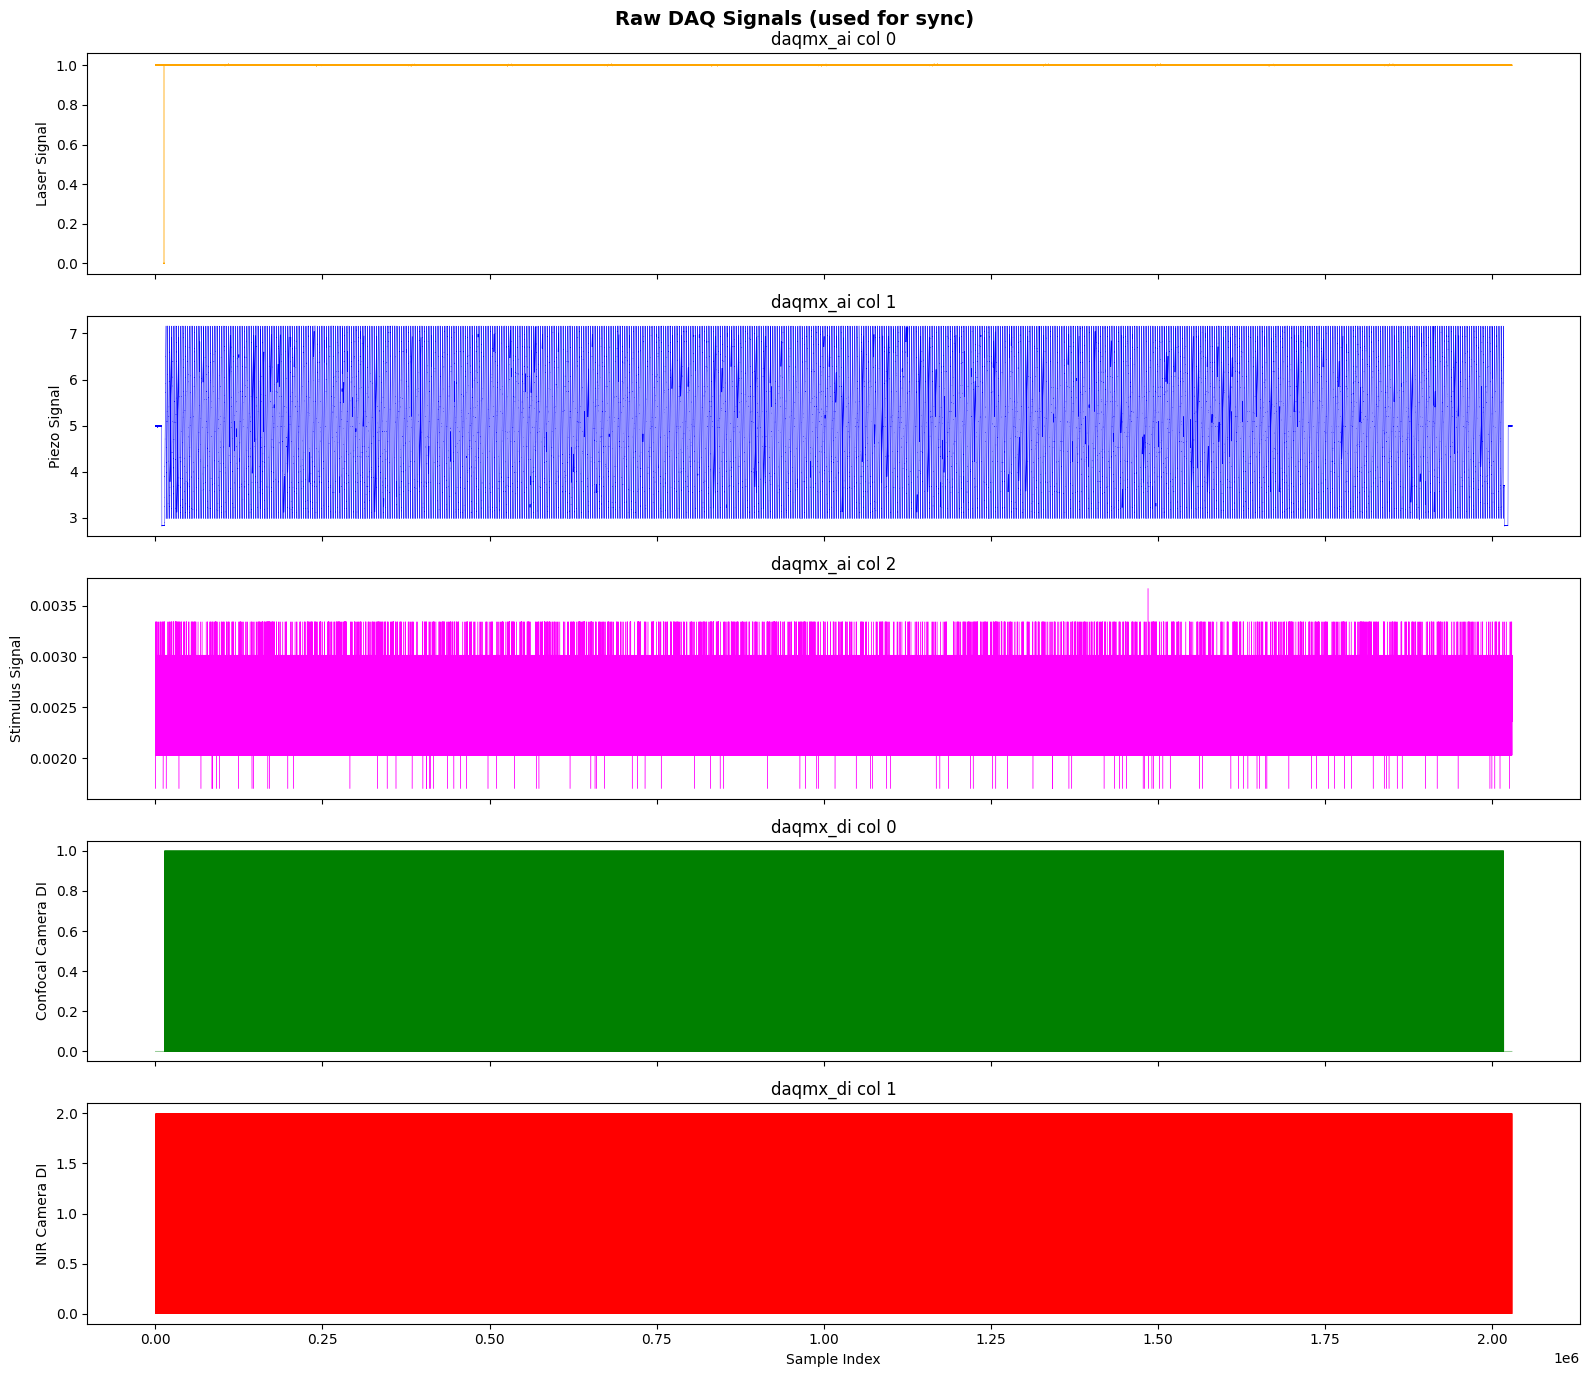


daqmx_ai shape: (3, 2029572)
daqmx_di shape: (2, 2029588)


In [6]:
# Quick visualization of the signals used for synchronization
import matplotlib.pyplot as plt

with h5py.File(h5_path, 'r') as f:
    daqmx_ai = f['daqmx_ai'][:]
    daqmx_di = f['daqmx_di'][:]

fig, axes = plt.subplots(5, 1, figsize=(16, 14), sharex=True)

labels = [
    ('daqmx_ai col 0', 'Laser Signal', 'orange'),
    ('daqmx_ai col 1', 'Piezo Signal', 'blue'),
    ('daqmx_ai col 2', 'Stimulus Signal', 'magenta'),
    ('daqmx_di col 0', 'Confocal Camera DI', 'green'),
    ('daqmx_di col 1', 'NIR Camera DI', 'red'),
]

# Plot analog inputs
for i in range(3):
    axes[i].plot(daqmx_ai[i, :] if daqmx_ai.shape[0] < daqmx_ai.shape[1] else daqmx_ai[:, i],
                 color=labels[i][2], linewidth=0.3)
    axes[i].set_ylabel(labels[i][1])
    axes[i].set_title(labels[i][0])

# Plot digital inputs
for i in range(2):
    axes[i+3].plot(daqmx_di[i, :] if daqmx_di.shape[0] < daqmx_di.shape[1] else daqmx_di[:, i],
                   color=labels[i+3][2], linewidth=0.3)
    axes[i+3].set_ylabel(labels[i+3][1])
    axes[i+3].set_title(labels[i+3][0])

axes[-1].set_xlabel('Sample Index')
plt.suptitle('Raw DAQ Signals (used for sync)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\ndaqmx_ai shape: {daqmx_ai.shape}")
print(f"daqmx_di shape: {daqmx_di.shape}")

<a id="part-4"></a>
## Part 4: Computing the Worm Spline (Julia)

The spline computation runs in **Julia** using the Flavell lab's `BehaviorDataNIR.jl` package. It:
1. Segments the worm from each NIR frame using a UNet2D model
2. Computes the medial axis (skeleton) of the worm
3. Fits a smooth spline along the medial axis
4. Detects omega turns and self-intersections
5. Recomputes a cleaned spline

See __NIR_behavioral_pipeline.jl.ipynb__

<a id="part-5"></a>
## Part 5: NIR–Confocal Synchronization (Python)

The NIR camera and confocal microscope run at different frame rates. We need to map each confocal volume (timepoint) to its corresponding NIR frame(s).

### How Synchronization Works

1. **Confocal timing:** Detected from the **piezo signal** (`daqmx_ai` col 1) — each peak = one 3D volume end
2. **NIR timing:** Detected from the **digital input** (`daqmx_di` col 1) — rising edges = frame starts
3. **NIR filtering:** Not all NIR triggers correspond to saved frames — we filter using `img_id` and `q_iter_save`
4. **Mapping:** For each confocal volume, we find which NIR frames fall within its time window

There are **two Python implementations** available:
- `sync_and_export.py` — Uses peak detection on piezo signal (simpler, recommended)
- `sync_nir_confocal_converted.py` — Converted from Julia, uses laser signal binarization (more complex)

### Method A: Using `sync_and_export.py` (Recommended)

> **Kernel:** Python (e.g., `g5ht-pipeline` or `nir-pipeline`)

In [ ]:
import sys, os, importlib
import numpy as np
import matplotlib.pyplot as plt

# Make sure nir/ is on the path
nir_dir = os.path.dirname(os.path.abspath('__file__'))  # adjust if needed
if nir_dir not in sys.path:
    sys.path.insert(0, nir_dir)

from sync_and_export import (
    sync_nir_confocal,
    plot_timing_validation,
    export_aligned_data,
    run_full_pipeline
)

raise NotImplementedError("Saving should go to the outputfolder/nir directory")

In [6]:
# ============================================================
# USER CONFIG — EDIT THESE
# ============================================================
PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113'
FN = 'date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004'  # without .h5
h5_path = os.path.join(PTH, FN + '.h5')

# Expected number of confocal VOLUMES/TIMEPOINTS (NOT z-slices per volume)
# e.g., if you imaged for ~10 min at ~0.5 sec/vol, this might be ~1200
# Set to None if unknown (will skip validation)
EXPECTED_N_VOLUMES = 882  # (can get this from bleach_corrected for now)

print(f"File: {h5_path}")
print(f"Exists: {os.path.exists(h5_path)}")

raise NotImplementedError("Expected n volumes should be automated")

File: C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004.h5
Exists: True


NotImplementedError: Expected n volumes should be automated

Loading data from: C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004.h5
  Loading daqmx_ai (analog inputs)...
  Loading daqmx_di (digital inputs)...
  Loading img_metadata...
  Loading pos_stage...
  Getting img_nir shape...
  Data loaded successfully!
    - NIR images: (9432, 732, 968) (n_frames, height, width)
    - DAQ samples: 3
    - Metadata entries: 18864

Detecting confocal timing from piezo signal...
  Found 883 peaks in piezo signal (confocal volumes/timepoints)


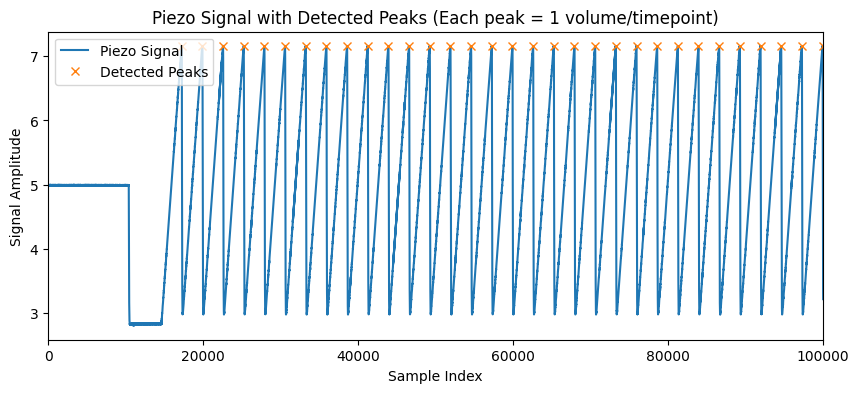

  Validating peak count against expected: 882 volumes
  Peak spacing: mean=2666.4, std=26.1, range=[1902, 2680]

Detecting NIR timing from digital input...
  Found 19190 total NIR triggers
  Image IDs range: 0 to 19187
  Frames marked for save: 9432 / 18864
  Saved frame IDs range: 0 to 19186
  Filtered NIR starts: 9432

Creating NIR-to-confocal mapping...
  Created mapping for 883 confocal volumes/timepoints
  NIR frame range: 59 to 9314

=== Synchronization Results ===
Confocal volumes detected: 883
NIR frames (filtered):     9432
Mapping length:            883
NIR frame range:           59 to 9314


c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\nir\sync_and_export.py:137: UserWarning: Expected 882 volumes but found 883 peaks. Difference: 1
  warnings.warn(


In [7]:
# ============================================================
# RUN SYNCHRONIZATION
# ============================================================
confocal_peaks, nir_starts, mapping, data = sync_nir_confocal(
    h5_path=h5_path,
    expected_n_volumes=EXPECTED_N_VOLUMES,
    min_peak_distance=100,   # Adjust if peaks are too close/far
    min_peak_prominence=1.0  # Adjust if peaks are too small/large
)

print(f"\n=== Synchronization Results ===")
print(f"Confocal volumes detected: {len(confocal_peaks)}")
print(f"NIR frames (filtered):     {len(nir_starts)}")
print(f"Mapping length:            {len(mapping)}")
print(f"NIR frame range:           {mapping.min()} to {mapping.max()}")

In [8]:
# ============================================================
# VALIDATION PLOTS
# ============================================================
plot_timing_validation(
    confocal_peaks, nir_starts, mapping, data,
    output_path=os.path.join(PTH, f'{FN}_validation_full.png')
)

# Zoomed view — first 10000 samples
plot_timing_validation(
    confocal_peaks, nir_starts, mapping, data,
    output_path=os.path.join(PTH, f'{FN}_validation_zoom.png'),
    plot_range=(0, 10000)
)


Generating validation plots...
  Saved validation plot: C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004_validation_full.png

  Mapping statistics:
    Mean increment: 10.49
    Std increment: 0.54
    Non-unity mappings: 882 / 882
  Saved mapping plot: C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004_validation_full_mapping.png

Generating validation plots...
  Saved validation plot: C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004_validation_zoom.png

  Mapping statistics:
    Mean increment: 10.49
    Std increment: 0.54
    Non-unity mappings: 882 / 882
  Saved mapping plot: C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004_validation_zoom_mapping.png


In [9]:
# ============================================================
# EXPORT ALIGNED DATA
# ============================================================
output_files = export_aligned_data(
    h5_path=h5_path,
    mapping=mapping,
    output_dir=PTH,
    save_nir=True,     # Save NIR images as TIFF (aligned to confocal)
    save_stage=True,   # Save stage positions as CSV
    save_metadata=True # Save sync metadata as NPZ
)

print("\nExported files:")
for key, path in output_files.items():
    print(f"  {key}: {path}")


Exporting aligned data...
  Loading and saving 883 NIR frames...
  Saved NIR images: C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004_nir_aligned.tif
    Shape: (883, 732, 968)
  Loading and saving stage positions...
  Saved stage positions: C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004_stage_aligned.csv
    Shape: (883, 2)
  Saving synchronization metadata...
  Saved metadata: C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004_sync_metadata.npz

  All exports complete!

Exported files:
  nir: C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004_nir_aligned.tif
  stage: C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004_stage_aligned.csv
  metadata: C:\Users\munib\P

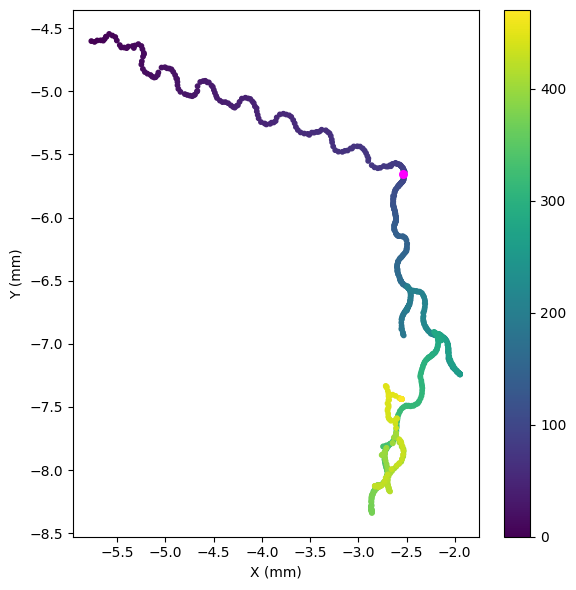

In [19]:
# load and plot stage data
pth = os.path.join(r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113','date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004_stage_aligned.csv')
stage_data = np.loadtxt(pth, delimiter=',', skiprows=1)

food_frame = 145+30
fps = 1/0.533

plt.figure(figsize=(6,6))
# color by time
plt.scatter(stage_data[:, 1]/10000, stage_data[:, 2]/10000, s=10, c=np.arange(0,stage_data[-1,0]+1)/fps, cmap='viridis')
# plt.plot(stage_data[:, 1]/10000, stage_data[:, 2]/10000,  color='blue')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.colorbar()
plt.scatter(stage_data[food_frame,1]/10000, stage_data[food_frame,2]/10000, s=30, c='magenta')

plt.tight_layout()
plt.show()


In [18]:
import cv2
import tifffile
import numpy as np
import os

# --- Setup Paths ---
pth = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113'
tif_name = 'date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004_nir_aligned.tif'
out_fn = os.path.join(pth, 'nir_video_aligned.mp4')

if not os.path.exists(pth):
    os.makedirs(pth)

# --- Load Data ---
im = tifffile.imread(os.path.join(pth, tif_name))
nframes, height, width = im.shape
save_fps = 8
frame_fps = 1/0.533  # Original acquisition fps

# --- Initialize Video Writer ---
# Use 'avc1' for H.264 (better compatibility) or 'mp4v' as you had it
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
# Note: We set isColor=True because we will convert the grayscale frame to BGR 
# This ensures the widest compatibility with players.
out = cv2.VideoWriter(out_fn, fourcc, save_fps, (width, height), isColor=True)

print(f'Starting save: {nframes} frames at {width}x{height}')

# --- Process and Save ---
for i in range(nframes):
    if i % 100 == 0:
        print(f'Saving frame: {i} / {nframes}')
    
    # 1. Slice and Normalize
    frame = im[i, :, :]
    # Use global max if possible to avoid flickering, 
    # but sticking to your per-frame logic here:
    f_max = np.max(frame)
    if f_max > 0:
        frame = (frame / f_max * 255).astype(np.uint8)
    else:
        frame = frame.astype(np.uint8)

    # 2. Overlay Text
    time_sec = i / frame_fps
    text = f'Confocal stack: {i}  Time: {time_sec:.2f} s'
    # For grayscale text, we use (255). 
    cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255), 2)

    # 3. Convert to BGR (Crucial for VideoWriter compatibility)
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    
    # 4. Write
    out.write(frame_bgr)

out.release()
print('Saved video to:', out_fn)

Starting save: 883 frames at 968x732
Saving frame: 0 / 883
Saving frame: 100 / 883
Saving frame: 200 / 883
Saving frame: 300 / 883
Saving frame: 400 / 883
Saving frame: 500 / 883
Saving frame: 600 / 883
Saving frame: 700 / 883
Saving frame: 800 / 883
Saved video to: C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113\nir_video_aligned.mp4


### Method B: Using `sync_nir_confocal_converted.py` (Julia-style)

This method mirrors the original Julia BehaviorDataNIR sync logic. It uses the laser signal instead of the piezo signal and provides bidirectional mappings.

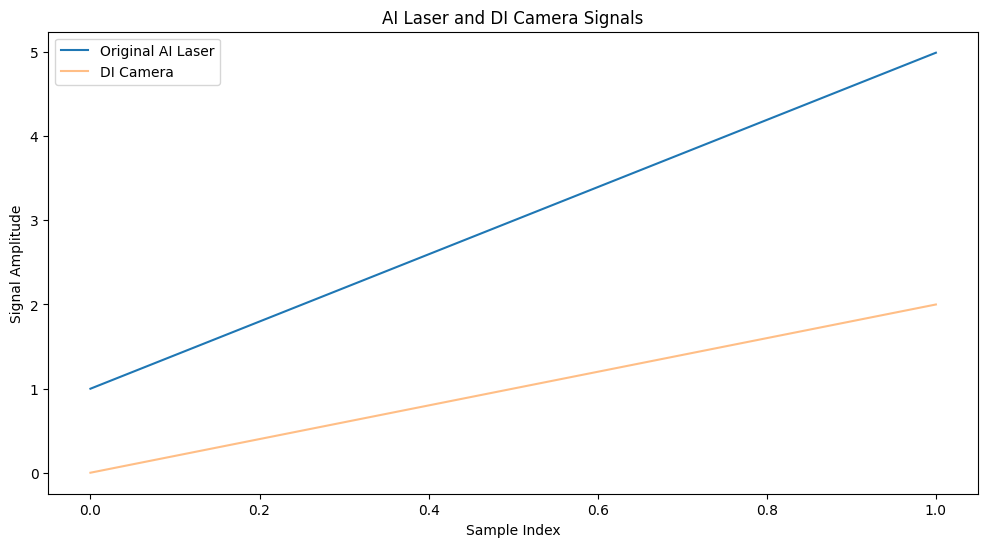

ValueError: filter_ai_laser: not enough recordings detected. check n_rec

In [20]:
from sync_nir_confocal_converted import sync_timing_from_file, get_timing_info, nir_vec_to_confocal

# Basic sync
confocal_to_nir, nir_to_confocal, timing_stack, timing_nir = sync_timing_from_file(
    h5_path, n_rec=1  # number of recording sessions in the file
)

print(f"Confocal stacks: {len(confocal_to_nir)}")
print(f"NIR frames:      {len(nir_to_confocal)}")
print(f"\nExample: confocal stack 0 corresponds to NIR frames: {confocal_to_nir[0]}")
print(f"Example: confocal stack 1 corresponds to NIR frames: {confocal_to_nir[1]}")

In [ ]:
# Full timing info with timestamps, stimulus detection, etc.
data_dict_py = {}
param_py = {
    'n_rec': 1,
    'max_t': len(confocal_to_nir),
    't_range': range(len(confocal_to_nir)),
    'FLIR_FPS': 30  # NIR camera FPS — check your setup (common: 20 or 30)
}

get_timing_info(
    data_dict=data_dict_py,
    param=param_py,
    path_h5=h5_path,
    h5_confocal_time_lag=0
)

print("data_dict keys after get_timing_info():")
for k, v in data_dict_py.items():
    if isinstance(v, np.ndarray):
        print(f"  {k:30s} shape={v.shape}")
    elif isinstance(v, list):
        print(f"  {k:30s} list, len={len(v)}")
    else:
        print(f"  {k:30s} = {v}")

<a id="part-6"></a>
## Part 6: Computing Behavioral Metrics (Julia)

After computing the spline (Part 4) and syncing timing, you can compute a full suite of behavioral metrics in Julia.

This uses `BehaviorDataNIR.jl` functions. Run this Julia code after you have a saved `data_dict.jld2`.

```julia
# ============================================================
# compute_behavior.jl — Full behavioral metrics
# ============================================================
# Run AFTER compute_spline.jl has produced a data_dict.jld2
# ============================================================

using HDF5, H5Zblosc, JLD2, BehaviorDataNIR, Statistics

# --- Config ---
NAME = "your_experiment_name"
PATH_H5   = "D:\\DATA\\g5ht-free\\20251028\\$(NAME).h5"
PATH_JLD2 = "D:\\DATA\\g5ht-free\\20251028\\$(NAME)_data_dict.jld2"

# Load previously saved data_dict (from spline computation)
data_dict = load(PATH_JLD2, "data_dict")

# ============================================================
# STEP 1: Add non-spline data (stage position, sync, etc.)
# ============================================================
# This function (from test.jl) computes:
#   - confocal_to_nir mapping
#   - max_t_nir, max_t, t_range
#   - x_stage, y_stage (interpolated stage positions)
#   - pm_angle (position–motion angle)
#   - x_med, y_med (offset-corrected coordinates)

function add_nonspline_data!(data_dict, path_h5)
    data_dict["confocal_to_nir"] = get_confocal_to_nir(path_h5)
    data_dict["max_t_nir"] = get_max_t_nir(path_h5)
    data_dict["max_t"] = get_max_t_confocal(
        data_dict["confocal_to_nir"], data_dict["max_t_nir"]
    )
    data_dict["t_range"] = 1:data_dict["max_t"]
    data_dict["confocal_to_nir"] = data_dict["confocal_to_nir"][data_dict["t_range"]]

    pos_feature, pos_feature_unet = read_pos_feature(path_h5)
    pos_stage = read_stage(path_h5)
    data_dict["x_stage"] = impute_list(pos_stage[1, :])
    data_dict["y_stage"] = impute_list(pos_stage[2, :])
    mn_vec, mp_vec, orthog_mp_vec = nmp_vec(pos_feature)
    data_dict["pm_angle"] = vec_to_angle(mp_vec)
    data_dict["x_med"], data_dict["y_med"] = offset_xy(
        data_dict["x_stage"], data_dict["y_stage"],
        pos_feature_unet[2, :, :]
    )
    nothing
end

add_nonspline_data!(data_dict, PATH_H5)

# ============================================================
# STEP 2: Compute all behavioral metrics
# ============================================================
# Parameters for behavioral analysis
param = Dict()
param["num_center_pts"]    = 1000
param["segment_len"]       = 7       # Body segment length for angle computation
param["max_pt"]            = 31      # Max body point for analysis
param["body_angle_t_lag"]  = 40      # Temporal lag for body angle
param["body_angle_pos_lag"]= 2       # Position lag for body angle
param["head_pts"]          = [1, 5, 8]   # Points defining head region
param["filt_len_angvel"]   = 150     # Filter length for angular velocity
param["FLIR_FPS"]          = 20.0    # NIR camera FPS
param["v_stage_m_filt"]    = 10      # Stage velocity median filter
param["v_stage_λ_filt"]    = 250.0   # Stage velocity smoothing
param["rev_len_thresh"]    = 2       # Reversal length threshold
param["rev_v_thresh"]      = -0.005  # Reversal velocity threshold
param["nose_pts"]          = [1, 2, 3]   # Points defining nose region

# Helper to bin NIR-rate data to confocal rate
vec_to_confocal = vec -> nir_vec_to_confocal(
    vec, data_dict["confocal_to_nir"], data_dict["max_t"]
)

# Interpolate splines for smooth derivatives
interpolate_splines!(data_dict)

# Segment end positions (for body angle computation)
data_dict["segment_end_matrix"] = get_segment_end_matrix(
    param, data_dict["x_array"], data_dict["y_array"]
)

# Stage position at confocal rate
data_dict["x_stage_confocal"] = vec_to_confocal(data_dict["x_stage"])
data_dict["y_stage_confocal"] = vec_to_confocal(data_dict["y_stage"])

# Zero-centered position
data_dict["zeroed_x"], data_dict["zeroed_y"] = zero_stage(
    data_dict["x_med"], data_dict["y_med"]
)
data_dict["zeroed_x_confocal"] = vec_to_confocal(data_dict["zeroed_x"])
data_dict["zeroed_y_confocal"] = vec_to_confocal(data_dict["zeroed_y"])

# Compute behavioral metrics
get_body_angles!(data_dict, param)      # Body angles along the worm
get_angular_velocity!(data_dict, param)  # Angular velocity
get_velocity!(data_dict, param)          # Forward/backward velocity
get_curvature_variables!(data_dict, param)  # Curvature
get_nose_curling!(data_dict, param)      # Nose curling metric

# Save updated data_dict
save(PATH_JLD2, "data_dict", data_dict)
println("Behavioral metrics computed and saved!")
```

### After Behavioral Computation, `data_dict` Contains:

| Key | Description |
|-----|-------------|
| `x_array`, `y_array` | Spline coordinates (NIR rate) |
| `nir_worm_angle` | Overall body angle (NIR rate) |
| `eccentricity` | Worm shape eccentricity |
| `confocal_to_nir` | List mapping confocal → NIR frames |
| `max_t`, `max_t_nir` | Max timepoints |
| `x_stage`, `y_stage` | Stage position (NIR rate) |
| `x_stage_confocal`, `y_stage_confocal` | Stage position (confocal rate) |
| `zeroed_x`, `zeroed_y` | Zero-centered position |
| `segment_end_matrix` | Body segment endpoints |
| `pm_angle` | Position–motion angle |
| Body angles, velocity, curvature, nose curl | Various behavioral features |

<a id="part-7"></a>
## Part 7: Working with Synced Data in Python

Once you have the sync mapping and behavioral data, here are common workflows.

In [ ]:
# ============================================================
# EXAMPLE: Align NIR-rate behavioral data to confocal timepoints
# ============================================================
from sync_nir_confocal_converted import nir_vec_to_confocal, sync_stim

# Suppose you have velocity data at NIR frame rate
# (e.g., loaded from a .jld2 file or computed separately)
n_nir_frames = len(nir_to_confocal)
example_nir_velocity = np.random.randn(n_nir_frames)  # replace with real data

# Align to confocal rate by averaging NIR frames within each confocal volume
confocal_velocity = nir_vec_to_confocal(
    example_nir_velocity, confocal_to_nir, len(confocal_to_nir)
)

print(f"NIR frames: {n_nir_frames} → Confocal volumes: {len(confocal_velocity)}")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=False)
axes[0].plot(example_nir_velocity[:500], 'b-', linewidth=0.5)
axes[0].set_title('Velocity at NIR rate (first 500 frames)')
axes[0].set_ylabel('Velocity')

axes[1].plot(confocal_velocity[:100], 'r-o', markersize=3)
axes[1].set_title('Velocity aligned to confocal rate (first 100 volumes)')
axes[1].set_ylabel('Velocity')
axes[1].set_xlabel('Confocal volume index')

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# EXAMPLE: Detect and align stimulus events
# ============================================================
import h5py

with h5py.File(h5_path, 'r') as f:
    ai_stim = f['daqmx_ai'][2, :] if f['daqmx_ai'].shape[0] < f['daqmx_ai'].shape[1] else f['daqmx_ai'][:, 2]

stim_confocal, stim_nir = sync_stim(ai_stim, timing_stack, timing_nir)

fig, axes = plt.subplots(3, 1, figsize=(14, 8))
axes[0].plot(ai_stim, 'm-', linewidth=0.3)
axes[0].set_title('Raw stimulus signal')
axes[0].set_ylabel('Voltage (V)')

axes[1].plot(stim_confocal, 'r-')
axes[1].set_title('Stimulus aligned to confocal rate')
axes[1].set_ylabel('Stimulus')

axes[2].plot(stim_nir, 'b-', linewidth=0.3)
axes[2].set_title('Stimulus aligned to NIR rate')
axes[2].set_ylabel('Stimulus')
axes[2].set_xlabel('Frame index')

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# EXAMPLE: Validate z-stack timing repeatability
# ============================================================
from sync_nir_confocal_converted import signal_stack_repeatability

with h5py.File(h5_path, 'r') as f:
    ai_piezo = f['daqmx_ai'][1, :] if f['daqmx_ai'].shape[0] < f['daqmx_ai'].shape[1] else f['daqmx_ai'][:, 1]

mean_piezo, std_piezo, time_arr, n_stacks = signal_stack_repeatability(
    ai_piezo, timing_stack, sampling_rate=5000
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(time_arr, mean_piezo * 10, 'k-', linewidth=1.5)
axes[0].fill_between(time_arr,
                     (mean_piezo - std_piezo) * 10,
                     (mean_piezo + std_piezo) * 10,
                     alpha=0.3, color='C0')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Piezo position (µm)')
axes[0].set_title(f'Stack Piezo ETA (n={n_stacks} stacks)')

axes[1].plot(std_piezo * 10 * 1000, 'C0-')
axes[1].set_xlabel('Sample within stack')
axes[1].set_ylabel('Repeatability (nm)')
axes[1].set_title('Piezo Repeatability')

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# EXAMPLE: View aligned NIR images
# ============================================================
import tifffile as tif

# If you exported aligned NIR images from Method A:
if 'nir' in output_files and os.path.exists(output_files['nir']):
    nir_aligned = tif.imread(output_files['nir'])
    print(f"Aligned NIR images shape: {nir_aligned.shape} (n_volumes, H, W)")

    fig, axes = plt.subplots(1, 5, figsize=(18, 4))
    idxs = np.linspace(0, len(nir_aligned) - 1, 5, dtype=int)
    for ax, idx in zip(axes, idxs):
        ax.imshow(nir_aligned[idx], cmap='gray')
        ax.set_title(f'Confocal vol {idx}')
        ax.axis('off')
    plt.suptitle('NIR images aligned to confocal volumes', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No exported NIR file found. Run the export step first (Part 5, Method A).")

In [ ]:
# ============================================================
# EXAMPLE: Load Julia data_dict results in Python
# ============================================================
# Julia saves data_dict as a .jld2 file. To read in Python,
# you can use the `pyjld2` or `julia` package, OR export from
# Julia to HDF5/NPZ format.
#
# Option 1: Export from Julia to HDF5
#   In Julia:
#     using HDF5
#     h5open("data_dict_export.h5", "w") do f
#         f["x_array"] = data_dict["x_array"]
#         f["y_array"] = data_dict["y_array"]
#         f["nir_worm_angle"] = data_dict["nir_worm_angle"]
#         f["eccentricity"] = data_dict["eccentricity"]
#     end
#
# Option 2: Read in Python
#   import h5py
#   with h5py.File('data_dict_export.h5', 'r') as f:
#       x_array = f['x_array'][:]
#       y_array = f['y_array'][:]
#       nir_worm_angle = f['nir_worm_angle'][:]
#       eccentricity = f['eccentricity'][:]

print("See comments above for how to export Julia data_dict to Python.")
print("Alternatively, install pyjld2: pip install pyjld2")
print("Then: from pyjld2 import load_jld2; data = load_jld2('data_dict.jld2')")

<a id="part-8"></a>
## Part 8: Troubleshooting

### Julia Issues

| Problem | Solution |
|---------|----------|
| `ERROR: LoadError: UndefVarError: create_model` | `UNet2D.jl` not installed correctly. Re-run `Pkg.add(url=...)` |
| `ERROR: could not load library` (CUDA) | Set `ENV["CUDA_VISIBLE_DEVICES"] = ""` to run on CPU |
| `MethodError: no method matching compute_worm_spline!` | Wrong Julia version. Must be **1.8.2** |
| `FileIO.jl: No saver found for .jld2` | Run `Pkg.add("JLD2")` and restart Julia |
| Package install fails (SSH) | Set up SSH keys: `ssh-keygen -t ed25519 -C "your_email"`, add to GitHub |
| `JULIA_DEPOT_PATH` not taking effect | Close all terminals, restart. Run `echo $env:JULIA_DEPOT_PATH` to verify |

### Python Sync Issues

| Problem | Solution |
|---------|----------|
| `"more than 2 recording on detected"` | Multiple recording sessions. Set `n_rec=2` (or higher) |
| `"detected trigger count different from image id"` | Data acquisition mismatch. Check HDF5 integrity |
| Peak detection finds wrong number of volumes | Adjust `min_peak_distance` and `min_peak_prominence` |
| Mapping has many duplicate entries | NIR frame rate is lower than confocal volume rate |
| `IndexError` in NIR timing | Some image IDs exceed trigger count. The code clips automatically |
| `daqmx_ai` shape confusion | Check if shape is `(n_samples, n_channels)` or `(n_channels, n_samples)` |

### Data Shape Notes

The HDF5 file may store `daqmx_ai` as either `(n_samples, n_channels)` or `(n_channels, n_samples)` depending on the acquisition software version. The sync code handles both, but if you get wrong results:

```python
# Check your data orientation:
with h5py.File(h5_path, 'r') as f:
    print(f"daqmx_ai shape: {f['daqmx_ai'].shape}")
    print(f"daqmx_di shape: {f['daqmx_di'].shape}")
    # If shape[0] < shape[1], channels are on axis 0 → index as [channel, :]
    # If shape[0] > shape[1], channels are on axis 1 → index as [:, channel]
```

## Summary: Complete Pipeline Order

```
┌─────────────────────────────────────────────┐
│       1. SETUP ENVIRONMENTS                 │
│  Julia 1.8.2 + packages  │  Python + conda  │
└────────────┬────────────────────┬────────────┘
             │                    │
             ▼                    │
┌────────────────────────┐       │
│  2. COMPUTE SPLINE     │       │
│  (Julia)               │       │
│  → data_dict.jld2      │       │
└────────────┬───────────┘       │
             │                    │
             ▼                    ▼
┌────────────────────────────────────────────┐
│  3. SYNC NIR ↔ CONFOCAL                    │
│  (Python or Julia)                          │
│  → confocal_to_nir, nir_to_confocal maps   │
│  → aligned NIR images, stage positions      │
└────────────┬───────────────────────────────┘
             │
             ▼
┌────────────────────────┐
│  4. BEHAVIORAL METRICS │
│  (Julia)               │
│  → velocity            │
│  → body angles         │
│  → curvature           │
│  → angular velocity    │
│  → nose curling        │
│  → reversals           │
└────────────┬───────────┘